We first install and import necessary packages.

In [ ]:
!pip install torch
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install stable-baselines3

In [1]:
import gymnasium as gym

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as functional

import matplotlib.pyplot as plt

## Lunar Lander

Next, we instantiate the [Lunar Lander environment](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) from OpenAI Gym and gain a quick understanding of its key variables and methods.

The Lunar Lander environment models a rocket that needs to land on the moon. Follow the hyperlinks to learn more about the envionment [Acrobot environment](https://www.gymlibrary.dev/environments/box2d/lunar_lander/). In this assignment, we will use the Continuous (v2) version of the environment in which both the state and action spaces are continuous.

![](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [2]:
env = gym.make("LunarLanderContinuous-v2")

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


#### States

OpenAI Gym environments do not explicitly provide state but instead provide observation. In the Lunar Lander environment, the state and observation are identical. The state of the Lander is a 8-dimensional vector: the coordinates of the lander in x and y, its linear velocities in x and y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [3]:
print(f"Number of state features: {env.observation_space.shape[0]}")

Number of state features: 8


#### Actions

The action space is also continous and includes two features. The first coordinate of an action determines the throttle of the main engine, while the second coordinate specifies the throttle of the lateral boosters.

Given an action `np.array([main, lateral])`, the main engine will be turned off completely if `main < 0` and the throttle scales affinely from 50% to 100% for `0 <= main <= 1` (i.e., the main engine doesn’t work with less than 50% power). Similarly, if `-0.5 < lateral < 0.5`, the lateral boosters will not fire at all. If `lateral < -0.5`, the left booster will fire, and if `lateral > 0.5`, the right booster will fire. Again, the throttle scales affinely from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively)

In [4]:
print(f"Number of action features: {env.action_space.shape[0]}")

Number of action features: 2


#### Transition and Reward Function

The transition and rewards functions for the environment are not explicitly represented as matrices or tensors. Instead the gym API provides access to the `step` method, which takes in as input an `action` and provides (among other things) an `observation` and `reward`. Also notice the `reset` method, which resets the MDP environment.

The following snippet describes the use of `step` and `reset` methods.

In [5]:
# Reset the environment
next_state = env.reset()
print(f"State: {next_state}")

# Select a random action to play
next_action = env.action_space.sample()
print(f"Action: {next_action}")

# Send this action to the environment to receive the next state and reward
next_state, reward, done, _, _ = env.step(next_action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")

State: (array([ 0.00640554,  1.416049  ,  0.6487917 ,  0.22793525, -0.00741558,
       -0.14696087,  0.        ,  0.        ], dtype=float32), {})
Action: [-0.19188674  0.02826439]
Next state: [ 0.01281128  1.4206004   0.6479144   0.20223632 -0.01467745 -0.14525
  0.          0.        ]
Reward: -0.29336092275366354


In [15]:
observation_n = env.observation_space.shape[0]
action_n = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

observation_n, action_n, max_action

(8, 2, 1.0)

## Point 1.1

Next, we will implement the general recipe of the DDPG algorithm to compute the optimal policy for the Lunar Lander.

#### Actor-Critic Networks

DDPG requires two networks: Actor and Critic. Let us know define these networks.

In [6]:
class Actor(nn.Module):
  """Actor Network as a Multi-Layer Perceptron."""

  def __init__(self, env, mlp_sizes=[256, 256]):
    """Initialize the Actor Network.

    Args:
        env: An OpenAI Gym environment.
        mlp_sizes: An array of integers. The length of array equals the number
            of hidden layers of the Multi-Layer Perceptron. Each element in the array
            equals the number of nodes in the corresponding layer.
    """
    super().__init__()

    observation_n = env.observation_space.shape[0]
    action_n = env.action_space.shape[0]

    # input layer
    self.input_layer = nn.Linear(observation_n, mlp_sizes[0])

    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for k in range(len(mlp_sizes) - 1):
        self.hidden_layers.append(nn.Linear(mlp_sizes[k], mlp_sizes[k + 1]))

    # output layer
    self.output_layer = nn.Linear(mlp_sizes[-1], action_n)
    

  def forward(self, x):
    """Implements the forward pass of the Actor Network.

    Args:
        x: Input to the Actor Network.

    Returns:
        Output of the Actor Network.
    """

    max_action = float(env.action_space.high[0])

    x = functional.relu(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
        x = functional.relu(hidden_layer(x))
    x = max_action * functional.tanh(self.output_layer(x))
    return x
  

In [7]:
class Critic(nn.Module):
  """Critic Network as a Multi-Layer Perceptron."""

  def __init__(self, env, mlp_sizes=[256, 256]):
    """Initialize the Critic Network.

    Args:
        env: An OpenAI Gym environment.
        mlp_sizes: An array of integers. The length of array equals the number
            of hidden layers of the Multi-Layer Perceptron. Each element in the array
            equals the number of nodes in the corresponding layer.
    """
    super().__init__()

    observation_n = env.observation_space.shape[0]
    action_n = env.action_space.shape[0]
    n_critic = 1

    # input layer
    self.input_layer = nn.Linear(observation_n + action_n, mlp_sizes[0])

    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for k in range(len(mlp_sizes) - 1):
        self.hidden_layers.append(nn.Linear(mlp_sizes[k], mlp_sizes[k + 1]))

    # output layer
    self.output_layer = nn.Linear(mlp_sizes[-1], n_critic)


  def forward(self, x):
    """Implements the forward pass of the Critic Network.

    Args:
        x: Input to the Critic Network.

    Returns:
        Output of the Critic Network.
    """

    x = functional.relu(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
        x = functional.relu(hidden_layer(x))
    x = self.output_layer(x)
    return x


#### Replay Buffer

DDPG requires a data structure to store the agent's experiences: Replay Buffer. Let us now define this data structure.

In [8]:
class ReplayBuffer:
  """A buffer to store agent's experiences."""

  def __init__(self, env, buffer_size):
    """Initialize a buffer to store agent's experiences.

    Args:
        env: An OpenAI Gym environment.
        buffer_size: An integer. The size of the buffer.
    """
    observation_n = env.observation_space.shape[0]
    action_n = env.action_space.shape[0]

    self.buffer_size = buffer_size
    self.observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
    self.next_observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
    self.actions = np.zeros((self.buffer_size, action_n), dtype=np.float32)
    self.rewards = np.zeros((self.buffer_size,), dtype=np.float32)
    self.dones = np.zeros((self.buffer_size,), dtype=np.float32)

    self.size = 0
    self.pos = 0

  def add(self, observation, next_observation, action, reward, done):
    """Add an experience to the buffer.

    Args:
        observation: the current environment state
        next_observation: the state after executing the action
        action: the action executed in the state
        reward: the reward received after executing the action
        done: Boolean denoting whether the task is completed.
    """
    self.observations[self.pos] = observation
    self.next_observations[self.pos] = next_observation
    self.actions[self.pos] = action
    self.rewards[self.pos] = reward
    self.dones[self.pos] = 1.0 if done else 0.0

    self.pos += 1
    if self.size < self.buffer_size:
      self.size += 1
    if self.pos == self.buffer_size:
      self.pos = 0

  def sample(self, batch_size):
    """Sample a mini-batch of experiences from the replay buffer.
    For ease of implementation, we sample with replacement.

    Args:
        batch_size: An integer. The size of the mini-batch.

    Returns:
        Randomly sampled experiences from the replay buffer.
    """
    indices = np.random.randint(self.size, size=batch_size)
    observations = torch.from_numpy(self.observations[indices])
    next_observations = torch.from_numpy(self.next_observations[indices])
    actions = torch.from_numpy(self.actions[indices])
    rewards = torch.from_numpy(self.rewards[indices])
    dones = torch.from_numpy(self.dones[indices])

    return observations, next_observations, actions, rewards, dones

#### Exploration schedule

In general, it is useful to explore more initially (when the agent is far from the optimal policy) and less later on in the learning process. To implement this, we can implement a schedule for epsilon.

Similar to the Actor and Critic networks and replay buffer architectures, several choices exist for determining the epsilon schedule. We will use a simple linear scheduler to decay epsilon as agent gains more experience.

In [9]:
def linear_schedule_for_epsilon(initial_value, final_value, duration, timestep):
  """Implements a linear scheduler for epsilon.

  Args:
      initial_value: (float) Initial value of epsilon.
      final_value: (float) Final value of epsilon.
      duration: (int) Duration over which to decay epsilon from its initial to final value.
      timestep: (int) The current time step.

  Returns:
      Value of epsilon at the given timestep.
  """
  slope = (final_value - initial_value) / duration
  return max(slope * timestep + initial_value, final_value)

#### Target Networks
In DDPG, we will update the target network in each iteration of the algorithm. A utility function to update the weights of the target network is provided below.

In [10]:
def update_weights(src, target, tau=1.0):
  """Utility function to update the target network using Polyak averaging.

  Args:
    src: (target network) source network
    target: (neural network) target network
    tau: (float) Polyak factor
  """

  for target_param, param in zip(target.parameters(), src.parameters()):
    target_param.data.copy_(
        target_param.data * (1.0 - tau) + param.data * tau
    )

#### DDPG algorithm

Now that we have all the building blocks, we will implement the DDPG algorithm.

We will use the AgentBase class from Assignment 2 to help us with the implementation.

In [11]:
class AgentBase:
  def __init__(self, env):
    self.env = env
    self.policy = self.make_policy()
    self.behavior_policy = self.make_behavior_policy()

  def make_policy(self):
    """
    Return a policy function that will be used for evaluation. The policy
    takes observation as input and return action
    """
    raise NotImplementedError

  def make_behavior_policy(self):
    """
    Similar to make_policy, it returns a policy function. But this one used
    for interaction with the environment.
    """
    raise NotImplementedError

  def run_episode(self, episode_policy):
    """
    Generate one episode with the given policy
    """
    episode = []
    done = False
    obs = self.env.reset()[0]
    episode_return = 0
    while not done:
      action = episode_policy(obs)
      next_obs, reward, done, truncated, _ = self.env.step(action)
      done = done or truncated
      episode.append([obs, action, reward, next_obs, done])
      obs = next_obs
      episode_return += reward

    return (episode, episode_return)

  def evaluate(self, num_eval_episodes=1000, plot_title="Evaluation"):
    """Evaluates the agent."""
    list_returns = []
    list_average_returns = []
    average_return = 0
    for episode_idx in range(num_eval_episodes):
      _, episode_return = self.run_episode(self.policy)
      average_return += (1. / (episode_idx+1)) * (episode_return - average_return)
      list_returns.append(episode_return)
      list_average_returns.append(average_return)

    print(f"Average reward {round(average_return, 3)}")
    plt.plot(list_returns,'^',label="Return")
    plt.plot(list_average_returns,'r',label="Average Return")
    plt.ylabel('Return')
    plt.xlabel('Episode#')
    plt.title(plot_title)
    plt.legend()
    plt.ylim(-501, 0.0)
    plt.show()

In [37]:
class DDPG(AgentBase):
  """Implements DDPG."""

  def __init__(
      self,
      env,
      actor_lr=0.0002,
      critic_lr=0.0003,
      total_timesteps=500000,
      buffer_size=50000,
      warmup_steps=1000,
      batch_size=64,
      tau=0.005,
      noise_std=0.1,
  ):
      """Initializes the Agent.
      Args:
          env: An OpenAI Gym environment.
          actor_lr: (float) Learning rate of actor
          critic_lr: (float) Learning rate of critic
          total_timesteps: (integer) The number of timesteps in training
          buffer_size: (integer) Size of the replay buffer.
          warmup_steps: (integer) Size of data for pre-filling buffer
          batch_size: (integer) Size of the mini batch.
          tau: (float) The amount of update to target actor/critic
          noise_std: (float) Initial noise level for exploration.
      """
      super().__init__(env=env)

      self.gamma = 0.99 # Assume a discount factor of 0.99
      self.env = env
      self.actor_lr = actor_lr
      self.critic_lr = critic_lr
      self.total_timesteps = total_timesteps
      self.buffer_size = buffer_size
      self.warmup_steps = warmup_steps
      self.batch_size = batch_size
      self.tau = tau
      self.noise_std = noise_std

      # Create actor and critic

      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      self.actor = Actor(env=env).to(self.device)
      self.actor_target = Actor(env=env).to(self.device)
      self.critic = Critic(env=env).to(self.device)
      self.critic_target = Critic(env=env).to(self.device)


      # Copy weights to target networks
      update_weights(self.actor, self.actor_target)
      update_weights(self.critic, self.critic_target)

      # Create optimizers
      self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
      self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

      # Create replay buffer
      self.replay_buffer = ReplayBuffer(env=env, buffer_size=buffer_size)

      # Create variables for logging
      self.obs = env.reset()[0]
      self.current_step = 0
      self.list_returns = []
      self.list_average_returns = []
      self.average_return = 0.
      self.list_moving_average_returns = []

  def make_policy(self):
    def policy_func(observation):
      state = torch.from_numpy(observation).to(self.device)
      action_probs: torch.Tensor = self.actor(state)
      action = action_probs.detach().cpu().numpy()
      return action

    return policy_func

  def make_behavior_policy(self):
    def policy_func(observation):
      state = torch.from_numpy(observation).to(self.device)
      action_probs: torch.Tensor = self.actor(state)
      
      # refs: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
      sigma = linear_schedule_for_epsilon(
        self.noise_std,
        self.noise_std * 0.1,
        self.total_timesteps * 0.9,
        self.current_step
      )
      mu = action_probs.detach().cpu().numpy()
      action = np.random \
        .normal(mu, sigma, env.action_space.shape) \
        .clip(env.action_space.low, env.action_space.high)

      return action

    return policy_func

  def update(self):
    if self.current_step > self.warmup_steps:

      # Sample a batch

      observations, next_observations, actions, rewards, dones = self.replay_buffer.sample(self.batch_size)
      observations = observations.to(self.device)
      next_observations = next_observations.to(self.device)
      actions = actions.to(self.device)
      rewards = rewards.to(self.device)
      dones = dones.to(self.device)

      # Get target values
      next_states = next_observations
      next_actions = self.actor_target(next_states)
      target_Q = self.critic_target(torch.cat([next_states, next_actions], dim=1)).view(-1)
      target_Q = rewards + self.gamma * target_Q * (1.0 - dones)
      target_Q = target_Q.detach().view(-1)

      # Decay learning rate
      # DO NOTHING

      # Update critic
      states = observations
      current_Q = self.critic(torch.cat([states, actions], dim=1)).view(-1)

      critic_loss = functional.mse_loss(current_Q, target_Q)

      self.critic_optim.zero_grad()
      critic_loss.backward()
      self.critic_optim.step()

      # Update actor
      another_states = observations
      another_actions = self.actor(another_states)
      another_Q = self.critic(torch.cat([another_states, another_actions], dim=1)).view(-1)
      
      actor_loss = -another_Q.mean()

      self.actor_optim.zero_grad()
      actor_loss.backward()
      self.actor_optim.step()

    # Update Target Network
    update_weights(self.actor, self.actor_target, self.tau)
    update_weights(self.critic, self.critic_target, self.tau)


  def train(self, make_plot=False):
    episode_return = 0.
    while self.current_step < self.total_timesteps:

      # Interact with env
      action = self.behavior_policy(self.obs)
      next_obs, reward, done, truncated, info = self.env.step(action)
      episode_return += reward
      done = done or truncated

      if done:
        # Store the return for evaluation
        self.list_returns.append(episode_return)
        episode_return = 0.
        self.average_return = np.mean(np.asarray(self.list_returns))
        self.list_average_returns.append(self.average_return)

        if len(self.list_average_returns) > 20:
          self.list_moving_average_returns.append(np.mean(self.list_returns[-20:]))
        else:
          self.list_moving_average_returns.append(self.average_return)

      # Save data into buffer
      self.replay_buffer.add(self.obs, next_obs, action, reward, done)

      # Update networks
      self.update()

      # Prepare for next iteration
      if done:
        self.obs = env.reset()[0]
      else:
        self.obs = next_obs

      if self.current_step % 1000 == 999:
        print(f"Timestep: {self.current_step+1}, episode reward (moving average, 20 episodes): {round(self.list_moving_average_returns[-1],2)}")
      self.current_step += 1

    if make_plot:
      plt.plot(self.list_returns,'^',label="Return")
      plt.plot(self.list_average_returns,'r',label="Average Return (all episodes)")
      plt.plot(self.list_moving_average_returns,'b',label="Average Return (last 20 episodes)")
      plt.ylabel('Return')
      plt.xlabel('Episode#')
      plt.title('Performance during training')
      plt.ylim(-501, 300)
      plt.legend()
      plt.show()

#### Training the Agent

Having implemented the agent, now we will train it using the default hyperparameters provided in the class definition and observe its performance.

In [38]:
env = gym.make("LunarLanderContinuous-v2")

Timestep: 1000, episode reward (moving average, 20 episodes): -133.44
Timestep: 2000, episode reward (moving average, 20 episodes): -200.41
Timestep: 3000, episode reward (moving average, 20 episodes): -214.63
Timestep: 4000, episode reward (moving average, 20 episodes): -180.81
Timestep: 5000, episode reward (moving average, 20 episodes): -163.51
Timestep: 6000, episode reward (moving average, 20 episodes): -151.35
Timestep: 7000, episode reward (moving average, 20 episodes): -159.95
Timestep: 8000, episode reward (moving average, 20 episodes): -158.04
Timestep: 9000, episode reward (moving average, 20 episodes): -137.29
Timestep: 10000, episode reward (moving average, 20 episodes): -142.7
Timestep: 11000, episode reward (moving average, 20 episodes): -153.23
Timestep: 12000, episode reward (moving average, 20 episodes): -154.13
Timestep: 13000, episode reward (moving average, 20 episodes): -155.37
Timestep: 14000, episode reward (moving average, 20 episodes): -158.42
Timestep: 15000,

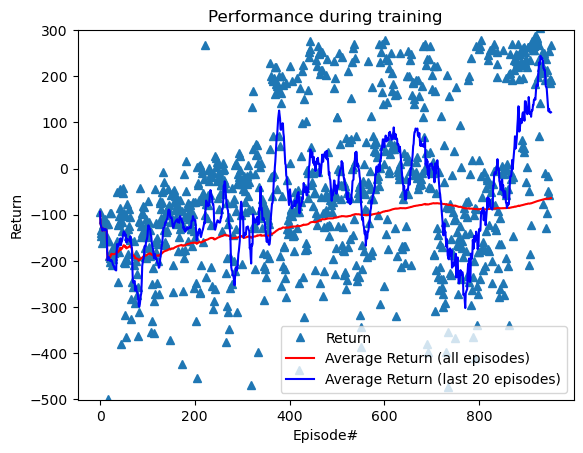

In [40]:
agent_001 = DDPG(env, total_timesteps=int(5e5))
agent_001.train(make_plot=True)

#### Comments 

`During the training process, the return values exhibit a spiral-shaped ascent.`  
`Additionally, due to a low lower bound and a high upper bound, the standard deviation is extremely large.`  
`That could be a result of the model exploring a diverse range of values during training, indicating variability and uncertainty in the learning process.`

## Point 1.2

The performance of RL algorithms typically varies across runs. Report results of five runs of your algorithm and summarize the performance in a single plot.

In [64]:
agents_5runs = []
for _ in range(5):
    agent = DDPG(env, total_timesteps=int(3e5))
    agent.train(make_plot=False)
    agents_5runs.append(agent)

Timestep: 1000, episode reward (moving average, 20 episodes): -152.45
Timestep: 2000, episode reward (moving average, 20 episodes): -254.93
Timestep: 3000, episode reward (moving average, 20 episodes): -273.12
Timestep: 4000, episode reward (moving average, 20 episodes): -234.54
Timestep: 5000, episode reward (moving average, 20 episodes): -192.29
Timestep: 6000, episode reward (moving average, 20 episodes): -175.22
Timestep: 7000, episode reward (moving average, 20 episodes): -158.57
Timestep: 8000, episode reward (moving average, 20 episodes): -160.26
Timestep: 9000, episode reward (moving average, 20 episodes): -177.87
Timestep: 10000, episode reward (moving average, 20 episodes): -181.93
Timestep: 11000, episode reward (moving average, 20 episodes): -187.61
Timestep: 12000, episode reward (moving average, 20 episodes): -191.8
Timestep: 13000, episode reward (moving average, 20 episodes): -196.18
Timestep: 14000, episode reward (moving average, 20 episodes): -210.35
Timestep: 15000,

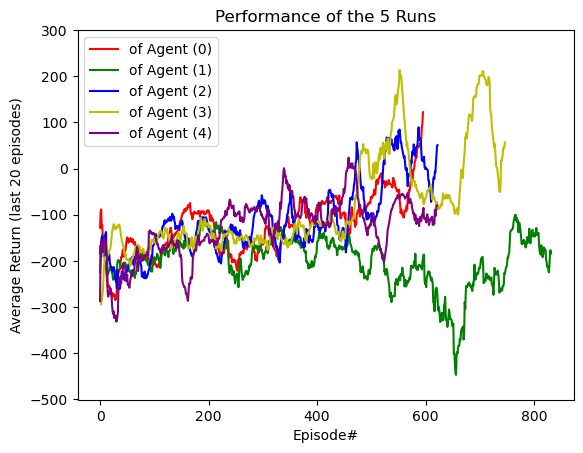

In [65]:
colors = ['r', 'g', 'b', 'y', 'purple']
for i in range(5):
    agent = agents_5runs[i]
    color = colors[i]
    plt.plot(agent.list_moving_average_returns, color, label=f"of Agent ({i})")
plt.ylabel('Average Return (last 20 episodes)')
plt.xlabel('Episode#')
plt.title('Performance of the 5 Runs')
plt.ylim(-501, 300)
plt.legend()
plt.show()

#### Comments 

`Because the algorithm is based on linear logic and cannot optimize for speed, in subsequent comparisons, I reduced the total_timesteps to 3e5 to observe results more quickly.`  
`It can be observed that, most of the time, the algorithm converges, but it is not always stable.`

## Point 1.3

Select any one hyperparameter of the algorithm and study its effect on the agent's performance.
You should try at least five different values of this hyperparameter and report on the observed performance. In a single plot, show the performance of the agent for different values of hyperparameter.  


In [66]:
learning_rates = [
    (0.0001, 0.0001),
    (0.0002, 0.0003),
    (0.001, 0.0003),
    (0.0002, 0.001),
    (0.001, 0.001),
]

agents_hyper = []
for actor_lr, critic_lr in learning_rates:
    agent = DDPG(env, total_timesteps=int(3e5), actor_lr=actor_lr, critic_lr=critic_lr)
    agent.train(make_plot=False)
    agents_hyper.append(agent)


Timestep: 1000, episode reward (moving average, 20 episodes): -144.93
Timestep: 2000, episode reward (moving average, 20 episodes): -152.76
Timestep: 3000, episode reward (moving average, 20 episodes): -132.35
Timestep: 4000, episode reward (moving average, 20 episodes): -150.32
Timestep: 5000, episode reward (moving average, 20 episodes): -163.04
Timestep: 6000, episode reward (moving average, 20 episodes): -177.09
Timestep: 7000, episode reward (moving average, 20 episodes): -174.95
Timestep: 8000, episode reward (moving average, 20 episodes): -197.31
Timestep: 9000, episode reward (moving average, 20 episodes): -209.32
Timestep: 10000, episode reward (moving average, 20 episodes): -193.92
Timestep: 11000, episode reward (moving average, 20 episodes): -162.03
Timestep: 12000, episode reward (moving average, 20 episodes): -174.84
Timestep: 13000, episode reward (moving average, 20 episodes): -194.83
Timestep: 14000, episode reward (moving average, 20 episodes): -213.7
Timestep: 15000,

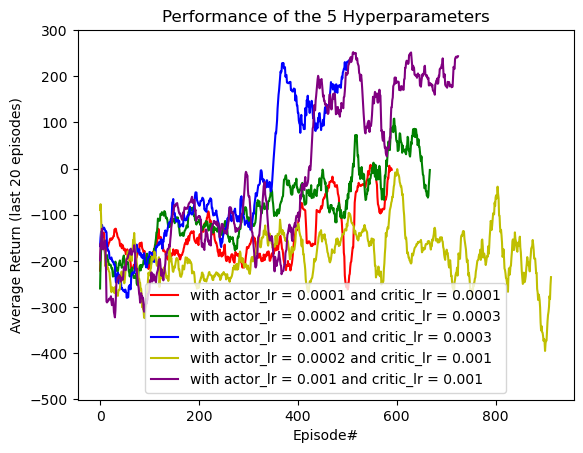

In [71]:
colors = ['r', 'g', 'b', 'y', 'purple']
for i in range(5):
    agent = agents_hyper[i]
    color = colors[i]
    actor_lr, critic_lr = learning_rates[i]
    plt.plot(agent.list_moving_average_returns, color, label=f"with actor_lr = {actor_lr} and critic_lr = {critic_lr}")
plt.ylabel('Average Return (last 20 episodes)')
plt.xlabel('Episode#')
plt.title('Performance of the 5 Hyperparameters')
plt.ylim(-501, 300)
plt.legend()
plt.show()

#### Comments 

`A lower learning rate does not necessarily result in a more stable standard deviation;`  
`on the contrary, a higher learning rate can lead to faster convergence to the target.`  
`Due to the algorithm's randomness in the exploration process, the significance of a single training with a specific hyperparameter is limited.`  

## Point 1.4

While applying RL in real world, you may consider the use of off-the-shelf implementation of RL algorithms. The package [Stable Baselines 3](stable-baselines3.readthedocs.io/) aims to provide a set of reliable implementations of RL algorithms in PyTorch.

Familiarize yourself with this package and use its implementation of DDPG to learn the optimal policy for the Lunar Lander environment.

In [50]:
import gymnasium as gym
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

class AverageEpisodeRewardsCallback(BaseCallback):
    """
    Stop the training once a maximum number of episodes are played.

    For multiple environments presumes that, the desired behavior is that the agent trains on each env for ``max_episodes``
    and in total for ``max_episodes * n_envs`` episodes.

    :param verbose: Verbosity level: 0 for no output, 1 for indicating information about when training ended by
        reaching ``max_episodes``
    """

    def __init__(
            self, 
            eval_env: gym.Env,
            n_eval_episodes: int = 20,
    ):
        super().__init__()

        self.eval_env = eval_env
        self.n_eval_episodes = n_eval_episodes

        self.n_episodes = 0
        self.rewards = []

    def _on_step(self) -> bool:
        # Check that the `dones` local variable is defined
        assert "dones" in self.locals, "`dones` variable is not defined, please check your code next to `callback.on_step()`"
        delta = np.sum(self.locals["dones"]).item()
        self.n_episodes += delta

        if delta > 0:
            mean_reward, std_reward = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                return_episode_rewards=False,
            )
            self.rewards.append(mean_reward)

        continue_training = True
        return continue_training

```yaml
LunarLanderContinuous-v2:
  n_timesteps: !!float 3e5
  policy: 'MlpPolicy'
  gamma: 0.98
  buffer_size: 200000
  learning_starts: 10000
  noise_type: 'normal'
  noise_std: 0.1
  gradient_steps: -1
  train_freq: [1, "episode"]
  learning_rate: !!float 1e-3
  policy_kwargs: "dict(net_arch=[400, 300])"
```

In [67]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DDPG as sb3_DDPG
from stable_baselines3.common.noise import NormalActionNoise

env = gym.make("LunarLanderContinuous-v2")
n_actions = env.action_space.shape[0]

noise_std = 0.1
action_noise =  NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=noise_std * np.ones(n_actions),
)

model = sb3_DDPG(
    policy="MlpPolicy",
    env=env,
    gamma=0.98,
    buffer_size=200000,
    learning_starts=1000,
    action_noise=action_noise,
    gradient_steps=-1,
    train_freq=(1,"episode"),
    learning_rate=1e-3,
    policy_kwargs=dict(net_arch=[400, 300]),
)

callback = AverageEpisodeRewardsCallback(env)
model.learn(total_timesteps=int(3e5), log_interval=4, callback=callback)


/root/miniforge3/envs/torch/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [68]:
len(callback.rewards)

884

In a single plot, compare the performance of your implementation of the algorithm in 1.1. with the one that you implemented above.

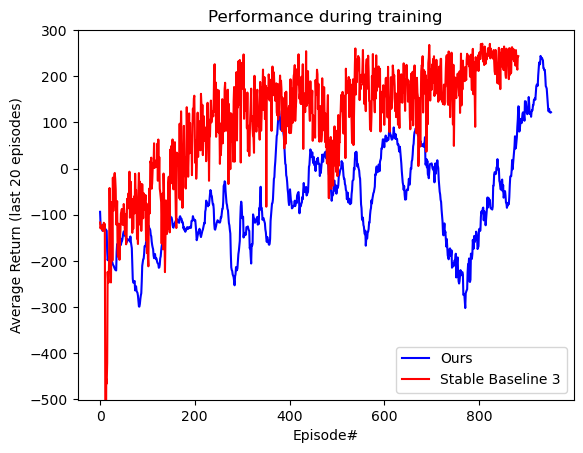

In [69]:
plt.plot(agent_001.list_moving_average_returns,'b',label="Ours")
plt.plot(callback.rewards,'r',label="Stable Baseline 3")
plt.ylabel('Average Return (last 20 episodes)')
plt.xlabel('Episode#')
plt.title('Performance during training')
plt.ylim(-501, 300)
plt.legend()
plt.show()

#### Comments 

`The optimal policy indeed proves to be more stable than our implementation, converging very rapidly and exhibiting less susceptibility to degradation.`  
`It took 3e5 timestamps to complete, whereas our implementation required 5e5 timestamps to achieve the same number of episodes.`